In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.random_projection import GaussianRandomProjection
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm
import sys

sys.path.append('../')
sys.path.append('../src/')
from src.generative import *
from src.detection import DataCopyingDetector, ThreeSampleDetector
from src.autoencoding import InceptionV3

In [2]:
# load data
emb_data = np.load("../data.nosync/imagenet_val_emb_data.npy")
print(f"Shape of data: {emb_data.shape}")

# perform PCA
pca = PCA(n_components=64)
pca.fit(emb_data)
pca_emb_data = pca.transform(emb_data)
print(f"Shape of PCA data: {pca_emb_data.shape}")

Shape of data: (50000, 2048)
Shape of PCA data: (50000, 64)


In [4]:
######## Data Copying Tests ########
n = 50000
idx_train = np.random.choice(len(pca_emb_data), size=n, replace=False)
X = pca_emb_data[idx_train]
idx_test = np.setdiff1d(np.arange(len(pca_emb_data)), idx_train)
X_test = pca_emb_data[idx_test]

print(f"Shape of training data: {X.shape}")
print(f"Shape of test data: {X_test.shape}")

copier = Memorizer().fit(X)
underfitter = Memorizer(radius=0.5, n_copying=len(X)).fit(X)
q = Mixture(rho=0.4, q1=copier, q2=underfitter)

X1_gen = q.sample(n)
X2_gen = q.sample(n)

k = 10  # number of projections
results = np.zeros((n, k)).astype(bool)
det = DataCopyingDetector()

for i in range(k):
    rp = GaussianRandomProjection(n_components=3).fit(X)
    copying_idx = det.get_copying_indices(
        rp.transform(X), rp.transform(X1_gen), rp.transform(X2_gen)
    )
    results[copying_idx, i] = True

Shape of training data: (50000, 64)
Shape of test data: (0, 64)


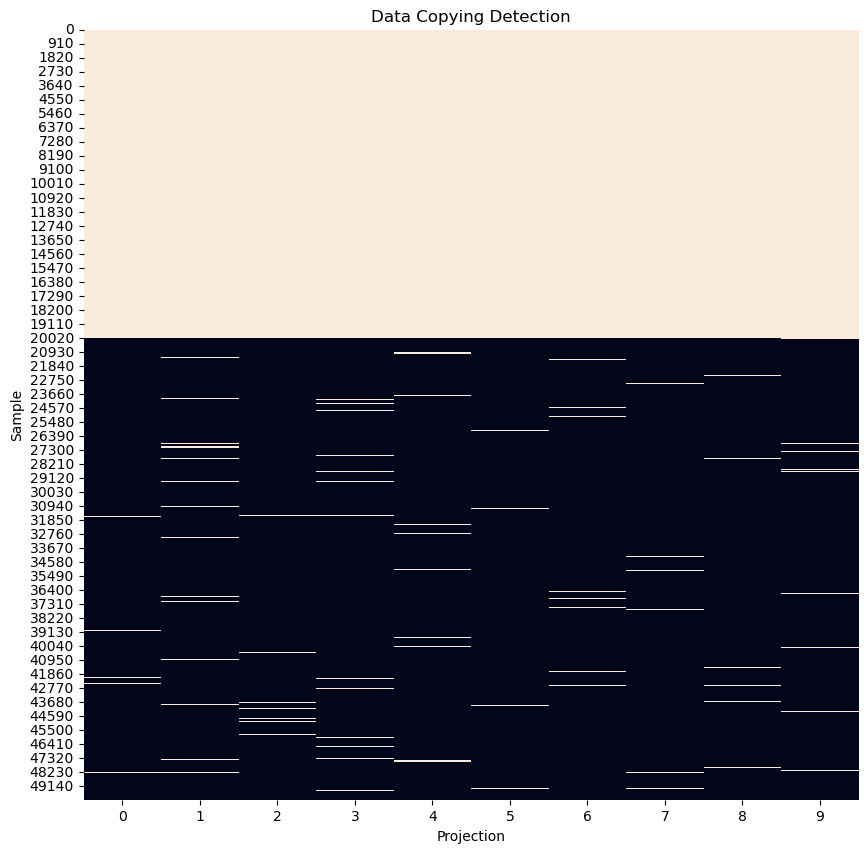

In [5]:
# plot results
plt.figure(figsize=(10, 10))
sns.heatmap(results, cbar=False)
plt.xlabel("Projection")
plt.ylabel("Sample")
plt.title("Data Copying Detection")
plt.show()

In [6]:
print(f"Majority vote: {(results.mean(axis=1) > 0.5).mean()}")
print(f"Mean aggregation: {results.mean()}")
print(f"Set aggregation: {results.any(axis=1).mean()}")

Majority vote: 0.40066
Mean aggregation: 0.415354
Set aggregation: 0.52898
